# 🧬 Tutorial 1: Data Extraction & Cleaning
## Working with ProteinGym DMS Data

---

**Learning Objectives:**
- Download and extract datasets from ProteinGym
- Clean and standardize tabular data with pandas
- Handle missing values and duplicates
- Normalize DMS scores for machine learning
- Visualize dataset characteristics

---

## 📥 Step 1: Data Download

We'll download the ProteinGym DMS (Deep Mutational Scanning) substitution dataset. Each CSV file represents one DMS experiment.

**Data Source:** [ProteinGym](https://proteingym.org/download) → DMS Assays → substitutions

In [13]:
# Download and extract ProteinGym DMS substitution dataset
import os

# Uncomment the lines below to download the data
# !wget -q https://marks.hms.harvard.edu/proteingym/ProteinGym_v1.3/DMS_ProteinGym_substitutions.zip -O DMS_ProteinGym_substitutions.zip
# !unzip -q DMS_ProteinGym_substitutions.zip -d ../ProteinGym_DMS_data
# !rm DMS_ProteinGym_substitutions.zip

# Check if data was downloaded successfully (should be in parent directory of notebook)
data_dir = "../ProteinGym_DMS_data/DMS_ProteinGym_substitutions"
if os.path.exists(data_dir) and os.path.isdir(data_dir):
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    if csv_files:
        print("✓ Data download complete!")
        print(f"  Found {len(csv_files)} CSV files in {data_dir}/")
    else:
        
        print(f"⚠ Directory {data_dir}/ exists but contains no CSV files.")
else:
    print(f"⚠ Data directory '{data_dir}/' not found.")
    print("  Please uncomment the download commands above and run the cell again.")

✓ Data download complete!
  Found 217 CSV files in ../ProteinGym_DMS_data/DMS_ProteinGym_substitutions/


## 📊 Step 2: Load and Inspect Data

Now we'll load all CSV files and combine them into a single DataFrame.

In [14]:
import pandas as pd
import numpy as np
import glob
import re

# Path to your DMS substitution data folder (relative to notebook location)
data_path = "../ProteinGym_DMS_data/DMS_ProteinGym_substitutions/*.csv"

# Load all CSVs into a list of dataframes
print("Loading CSV files...")
dfs = []
csv_files = glob.glob(data_path)

if not csv_files:
    print(f"⚠ No CSV files found at path: {data_path}")
    print("  Please make sure the data has been downloaded first (run Step 1 cell above).")
else:
    for f in csv_files:
        df = pd.read_csv(f)
        df["source_file"] = f.split("/")[-1].replace(".csv", "")
        dfs.append(df)
    
    # Combine into a single dataframe
    data = pd.concat(dfs, ignore_index=True)
    
    print(f"✓ Loaded {len(dfs)} files with {len(data):,} total rows")

Loading CSV files...
✓ Loaded 217 files with 2,465,767 total rows


### 🔍 Quick Data Inspection

In [16]:
# Display first few rows
print("First 5 rows of the dataset:")
data.head()

First 5 rows of the dataset:


,mutant,mutated_sequence,DMS_score,DMS_score_bin,source_file,DMS_bin_score
0,A16C,MRKLSDELLIESYFKCTEMNLNRDFIELIENEIKRRSLGHIISV,-0.533935,1,SDA_BACSU_Tsuboyama_2023_1PV0,NaN
1,A16D,MRKLSDELLIESYFKDTEMNLNRDFIELIENEIKRRSLGHIISV,-2.151397,0,SDA_BACSU_Tsuboyama_2023_1PV0,NaN
2,A16E,MRKLSDELLIESYFKETEMNLNRDFIELIENEIKRRSLGHIISV,-0.870078,1,SDA_BACSU_Tsuboyama_2023_1PV0,NaN
3,A16F,MRKLSDELLIESYFKFTEMNLNRDFIELIENEIKRRSLGHIISV,-0.328954,1,SDA_BACSU_Tsuboyama_2023_1PV0,NaN
4,A16G,MRKLSDELLIESYFKGTEMNLNRDFIELIENEIKRRSLGHIISV,-0.961885,1,SDA_BACSU_Tsuboyama_2023_1PV0,NaN


In [17]:
# Get data types and missing values info
print("Dataset information:")
data.info()

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465767 entries, 0 to 2465766
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   mutant            object 
 1   mutated_sequence  object 
 2   DMS_score         float64
 3   DMS_score_bin     int64  
 4   source_file       object 
 5   DMS_bin_score     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 112.9+ MB


In [18]:
# Count unique mutants
num_unique = data['mutant'].nunique()
print(f"Number of unique mutants: {num_unique:,}")

Number of unique mutants: 1,970,601


## 🧹 Step 3: Data Cleaning

### 3.1 Standardize Column Names

Let's rename columns to have consistent, clear names throughout our analysis.

In [19]:
# Make column names consistent and easier to work with
df = data.rename(columns={
    'DMS_score': 'score',
    'mutant': 'mutation',
    'mutated_sequence': 'mut_seq',
    'DMS_score_bin': 'score_bin',
    'DMS_bin_score': 'score_bin_float'
})

print("✓ Column names standardized")
print(f"New columns: {list(df.columns)}")

✓ Column names standardized
New columns: ['mutation', 'mut_seq', 'score', 'score_bin', 'source_file', 'score_bin_float']


### 3.2 Parse Mutation Strings

Extract wildtype amino acid, position, and mutant amino acid from mutation notation (e.g., "A123C").

In [ ]:
def parse_mut(m):
    """
    Parse mutation string (e.g., 'A123C') into components.
    Returns: (wildtype_aa, position, mutant_aa)
    """
    match = re.match(r"([A-Z])(\d+)([A-Z])", str(m))
    if match:
        wt, pos, mut = match.groups()
        return pd.Series([wt, int(pos), mut])
    return pd.Series([np.nan, np.nan, np.nan])


def parse_mut(m):
    if type(m) == str:
        wt_aa = m[0]
        mut_aa = m[-1]
        position = int(m[1:-1])
        return pd.Series([wt_aa, position, mut_aa])
    return pd.Series([np.nan, np.nan, np.nan])


# Apply parsing to all mutations; this may take a moment
df[['wt_aa', 'position', 'mut_aa']] = df['mutation'].apply(parse_mut)

print("✓ Mutations parsed successfully")
print(f"Example: {df[['mutation', 'wt_aa', 'position', 'mut_aa']].head(3)}")

✓ Mutations parsed successfully
Example:   mutation wt_aa  position mut_aa
0     A16C     A        16      C
1     A16D     A        16      D
2     A16E     A        16      E


### 3.3 Remove Invalid and Duplicate Entries

In [21]:
# Store original size
original_size = len(df)

# Drop rows with missing values in critical columns
df = df.dropna(subset=['score', 'mutation', 'wt_aa', 'mut_aa'])

# Remove duplicate entries (same mutation in same source file)
df = df.drop_duplicates(subset=['source_file', 'mutation'])

print(f"✓ Removed {original_size - len(df):,} invalid/duplicate entries")
print(f"✓ Final dataset size: {len(df):,} rows")

✓ Removed 0 invalid/duplicate entries
✓ Final dataset size: 2,465,767 rows


## 📏 Step 4: Score Normalization

DMS scores can vary widely across different experiments. We'll normalize scores per experiment to help machine learning models generalize better.

**Why normalize?** Each experiment has its own scale. Standardizing to mean ≈ 0 and std ≈ 1 allows fair comparison across experiments.

### 4.1 Examine Score Distribution

In [22]:
# Examine the raw score distribution
print("Raw DMS Score Statistics:")
print(f"  Maximum: {df['score'].max():.4f}")
print(f"  Minimum: {df['score'].min():.4f}")
print(f"  Mean:    {df['score'].mean():.4f}")
print(f"  Std Dev: {df['score'].std():.4f}")

Raw DMS Score Statistics:
  Maximum: 100215199.6500
  Minimum: -205.5000
  Mean:    1804.6449
  Std Dev: 245399.7809


/opt/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


<Axes: xlabel='score', ylabel='Count'>

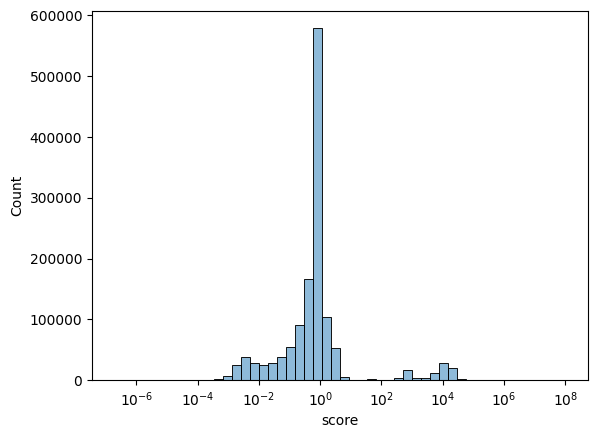

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df['score'], bins=50, kde=True, log_scale=(True, False))

### 4.2 Apply Z-Score Normalization

In [28]:
# Normalize scores per experiment (z-score normalization)
df['score_norm'] = df.groupby('source_file')['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

print("✓ Scores normalized per experiment")

✓ Scores normalized per experiment


### 4.3 Verify Cleaned Dataset

In [ ]:
# Quick inspection of cleaned data
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nExperiment sizes:")
df.groupby('source_file').size().describe()

Dataset shape: (2465767, 10)

First few rows:
  mutation                                       mut_seq     score  score_bin  \
0     A16C  MRKLSDELLIESYFKCTEMNLNRDFIELIENEIKRRSLGHIISV -0.533935          1   
1     A16D  MRKLSDELLIESYFKDTEMNLNRDFIELIENEIKRRSLGHIISV -2.151397          0   
2     A16E  MRKLSDELLIESYFKETEMNLNRDFIELIENEIKRRSLGHIISV -0.870078          1   
3     A16F  MRKLSDELLIESYFKFTEMNLNRDFIELIENEIKRRSLGHIISV -0.328954          1   
4     A16G  MRKLSDELLIESYFKGTEMNLNRDFIELIENEIKRRSLGHIISV -0.961885          1   

                     source_file  score_bin_float wt_aa  position mut_aa  \
0  SDA_BACSU_Tsuboyama_2023_1PV0              NaN     A        16      C   
1  SDA_BACSU_Tsuboyama_2023_1PV0              NaN     A        16      D   
2  SDA_BACSU_Tsuboyama_2023_1PV0              NaN     A        16      E   
3  SDA_BACSU_Tsuboyama_2023_1PV0              NaN     A        16      F   
4  SDA_BACSU_Tsuboyama_2023_1PV0              NaN     A        16      G   

   score_n

count       217.000000
mean      11362.981567
std       51668.145610
min          63.000000
25%        1332.000000
50%        2339.000000
75%        6769.000000
max      536962.000000
dtype: float64

In [32]:
# Display the full cleaned dataset
# df

### 4.4 Verify Normalization

In [31]:
# Sanity check: verify normalization worked correctly
# Each experiment should have mean ≈ 0 and std ≈ 1
print("Normalized scores per experiment (first 10):")
normalization_check = df.groupby('source_file')['score_norm'].agg(['mean', 'std'])
print(normalization_check.head(10))

print("\n✓ Normalization successful!" if (abs(normalization_check['mean'].mean()) < 0.01) else "⚠ Check normalization")

Normalized scores per experiment (first 10):
                                          mean  std
source_file                                        
A0A140D2T1_ZIKV_Sourisseau_2019   1.350679e-17  1.0
A0A192B1T2_9HIV1_Haddox_2018     -2.994257e-17  1.0
A0A1I9GEU1_NEIME_Kennouche_2019   2.432376e-17  1.0
A0A247D711_LISMN_Stadelmann_2021  4.473131e-17  1.0
A0A2Z5U3Z0_9INFA_Doud_2016        2.630757e-17  1.0
A0A2Z5U3Z0_9INFA_Wu_2014          1.573210e-17  1.0
A4D664_9INFA_Soh_2019             8.913503e-17  1.0
A4GRB6_PSEAI_Chen_2020            1.362708e-16  1.0
A4_HUMAN_Seuma_2022               8.605334e-18  1.0
AACC1_PSEAI_Dandage_2018         -7.626077e-18  1.0

✓ Normalization successful!


### 4.5 Save Cleaned Dataset

Let's save our cleaned and normalized data for future use.

In [33]:
# Save cleaned dataset to CSV
output_dir = "../ProteinGym_DMS_data"
output_file = f"{output_dir}/cleaned_ProteinGym_DMS_substitutions.csv"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save to CSV
df.to_csv(output_file, index=False)

print(f"✓ Cleaned dataset saved to: {output_file}")
print(f"  Total rows: {len(df):,}")
print(f"  Total columns: {len(df.columns)}")

✓ Cleaned dataset saved to: ../ProteinGym_DMS_data/cleaned_ProteinGym_DMS_substitutions.csv
  Total rows: 2,465,767
  Total columns: 10


## 🎯 Ready for Machine Learning!

Your cleaned dataset is now ready to use with protein language models:

**Options:**
- Feed `mut_seq` (mutated sequences) directly to models like **ESM-2**, **ProteinBERT**, or **ProtT5**
- Use `(wildtype_sequence, mutation)` pairs for models that support variant input
- Use `score_norm` as regression targets
- Use `score_bin` for classification tasks

---

## 📊 Step 5: Data Visualization

Let's explore our cleaned dataset visually to understand its characteristics and identify potential issues.

### 5.1 Setup Visualization Libraries

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Quick sanity check
print("Dataset Summary Statistics:")
print(df.describe())
print("\n" + "="*50)

Dataset Summary Statistics:
              score     score_bin  score_bin_float      position    score_norm
count  2.465767e+06  2.465767e+06      4670.000000  2.465767e+06  2.465767e+06
mean   1.804645e+03  5.646568e-01         0.500000  1.940831e+02 -4.262507e-17
std    2.453998e+05  4.958020e-01         0.500054  1.690607e+02  9.999562e-01
min   -2.055000e+02  0.000000e+00         0.000000  1.000000e+00 -1.006512e+01
25%   -9.108713e-01  0.000000e+00         0.000000  6.500000e+01 -8.742485e-01
50%    1.050000e-02  1.000000e+00         0.500000  1.780000e+02  6.697107e-02
75%    8.713833e-01  1.000000e+00         1.000000  2.650000e+02  8.001611e-01
max    1.002152e+08  1.000000e+00         1.000000  2.654000e+03  3.183003e+01



### 5.2 DMS Score Distributions

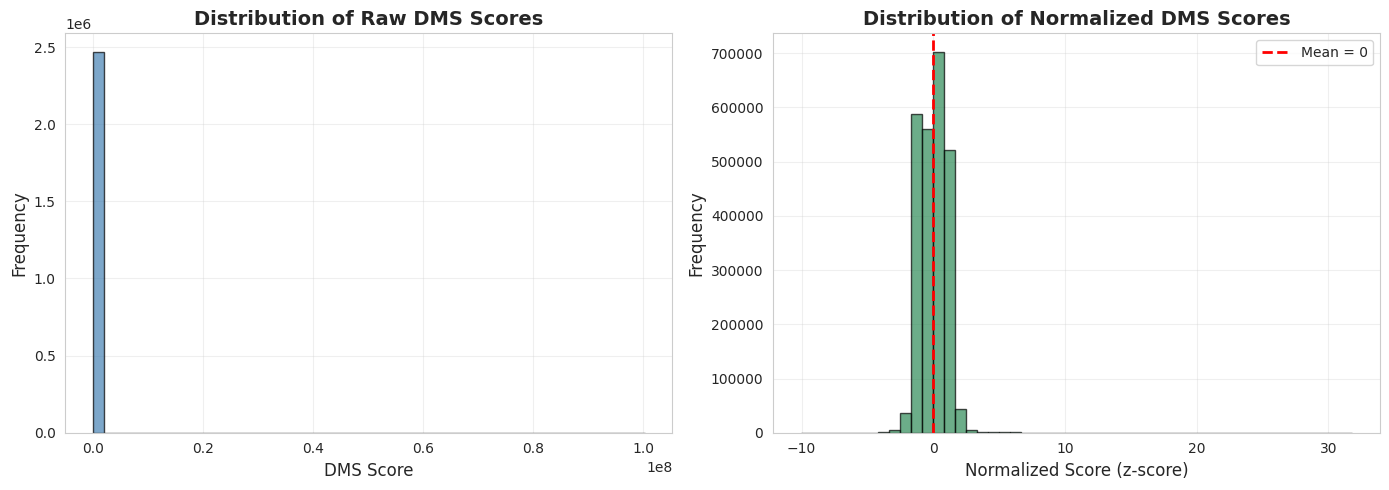

✓ Score distributions look good! Normalization has centered the data around 0.


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw DMS scores
axes[0].hist(df['score'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_title("Distribution of Raw DMS Scores", fontsize=14, fontweight='bold')
axes[0].set_xlabel("DMS Score", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].grid(alpha=0.3)

# Normalized DMS scores
axes[1].hist(df['score_norm'], bins=50, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].set_title("Distribution of Normalized DMS Scores", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Normalized Score (z-score)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Mean = 0')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Score distributions look good! Normalization has centered the data around 0.")

### 5.3 Mutation Type Analysis

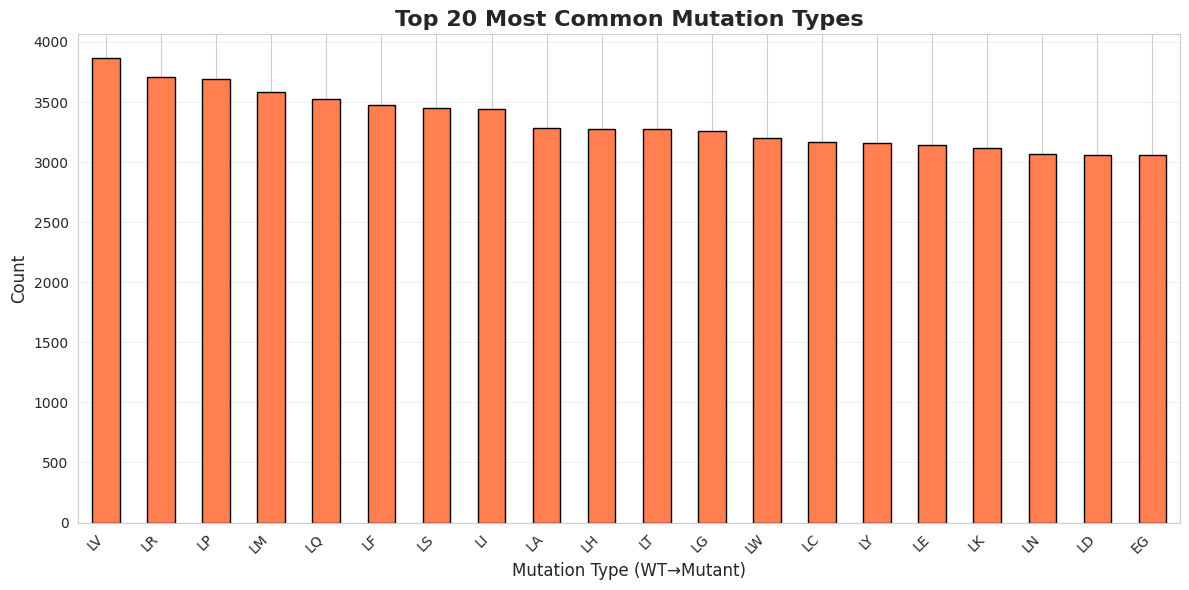

✓ Found 992040 unique mutation types


In [36]:
# Extract mutation type (e.g., 'A123C' → 'AC')
df['mutation_type'] = df['mutation'].str.replace(r'[0-9]', '', regex=True)
top_mutations = df['mutation_type'].value_counts().head(20)

plt.figure(figsize=(12, 6))
top_mutations.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Top 20 Most Common Mutation Types', fontsize=16, fontweight='bold')
plt.xlabel("Mutation Type (WT→Mutant)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Found {df['mutation_type'].nunique()} unique mutation types")

### 5.4 Sequence Length Distribution

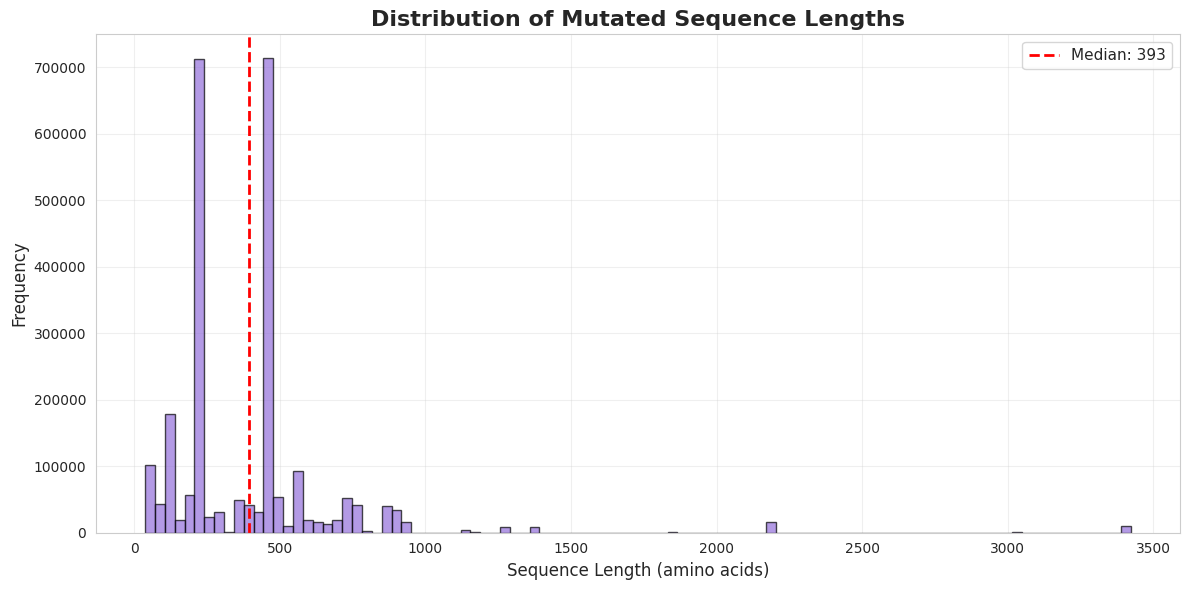

Sequence length stats:
  Min: 37
  Max: 3423
  Median: 393


In [38]:
# Calculate sequence lengths
df['seq_length'] = df['mut_seq'].str.len()

plt.figure(figsize=(12, 6))
plt.hist(df['seq_length'], bins=100, color='mediumpurple', alpha=0.7, edgecolor='black')
plt.title("Distribution of Mutated Sequence Lengths", fontsize=16, fontweight='bold')
plt.xlabel("Sequence Length (amino acids)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(df['seq_length'].median(), color='red', linestyle='--', linewidth=2, 
            label=f'Median: {df["seq_length"].median():.0f}')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Sequence length stats:")
print(f"  Min: {df['seq_length'].min()}")
print(f"  Max: {df['seq_length'].max()}")
print(f"  Median: {df['seq_length'].median():.0f}")

### 5.5 Wild-Type Amino Acid Distribution

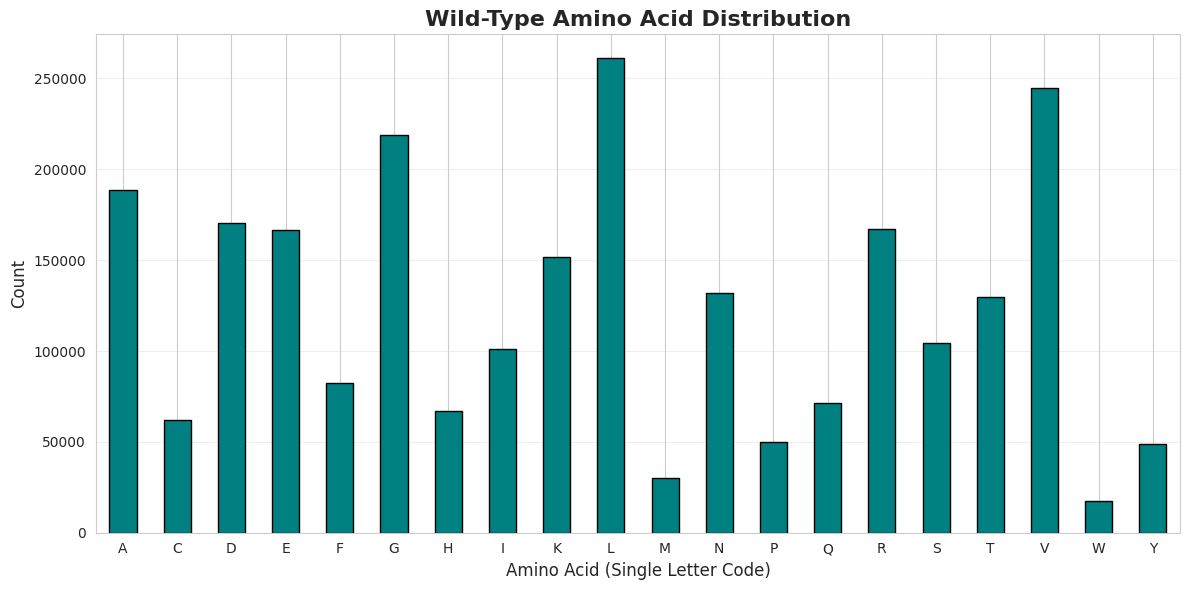

✓ All 20 standard amino acids represented!


In [39]:
# Count wild-type amino acids
wt_counts = df['wt_aa'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
wt_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Wild-Type Amino Acid Distribution', fontsize=16, fontweight='bold')
plt.xlabel("Amino Acid (Single Letter Code)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ All 20 standard amino acids represented!" if len(wt_counts) == 20 else f"Found {len(wt_counts)} amino acids")

---

## 🎉 Tutorial Complete!

**What we accomplished:**
1. ✅ Downloaded and loaded ProteinGym DMS data
2. ✅ Cleaned and standardized the dataset
3. ✅ Parsed mutation strings into components
4. ✅ Normalized DMS scores for ML readiness
5. ✅ Visualized key dataset characteristics

**Next steps:**
- Use this cleaned data with protein language models (ESM-2, ProteinBERT, ProtT5)
- Build predictive models for mutation effects
- Explore uncertainty quantification techniques

---